In [1]:
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
from numpy import loadtxt
from PIL import Image
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import os
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy

In [2]:
DATASET = '__FULL'

In [3]:
def get_ds(root, max_size=1024):
    # Applying Transforms to the Data
    image_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
    ])
    
    directories = {
        type_: os.path.join(root, type_) for type_ in next(os.walk(root))[1]
    }
    types = directories.keys()

    # Batch size
    bs = 128

    # Number of classes
    num_classes = 2

    # Load Data from folders
    ds = {
        type_: datasets.ImageFolder(root=directories[type_], transform=image_transform)
                                    for type_ in  directories
    }
    
    dls = {type_: torch.utils.data.DataLoader(ds[type_], batch_size=bs, shuffle=True, num_workers=4)
              for type_ in types
    }
    dls = {type_: {"dl": dls[type_], "size": len(ds[type_]), "cls": ds[type_].classes} for type_ in types}
    return dls

['correct', 'incorrect']


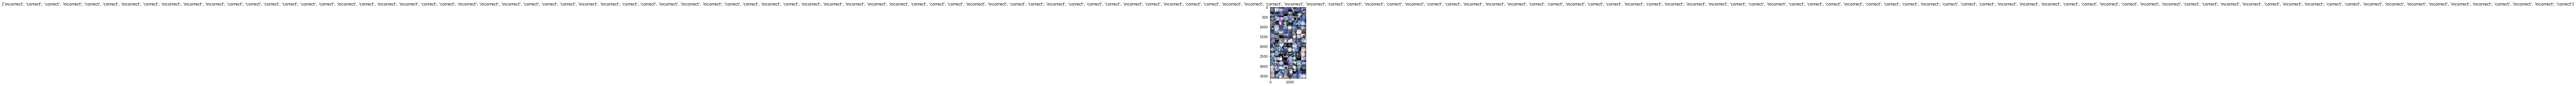

In [4]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataloaders = get_ds(DATASET)


class_names = dataloaders['train']['cls']
print(class_names)
inputs, classes = next(iter(dataloaders['train']['dl']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t0 = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            full_len = len(dataloaders[phase]["dl"].dataset)
            completed = 0
            for inputs, labels in dataloaders[phase]["dl"]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                completed += len(labels)
                print(f"{completed}/{full_len}")
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            t1 = time.time()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataloaders[phase]["size"]
            epoch_acc = running_corrects.double() / dataloaders[phase]["size"]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print(f"time: {t1-t0}")
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [7]:
# Model modification #
# ================== #
model.fc = nn.Linear(1024, 2)

In [8]:
# Learning parameters #
# =================== #

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9
----------
128/42761
256/42761
384/42761
512/42761
640/42761
768/42761
896/42761
1024/42761
1152/42761
1280/42761
1408/42761
1536/42761
1664/42761
1792/42761
1920/42761
2048/42761
2176/42761
2304/42761
2432/42761
2560/42761
2688/42761
2816/42761
2944/42761
3072/42761
3200/42761
3328/42761
3456/42761
3584/42761
3712/42761
3840/42761
3968/42761
4096/42761
4224/42761
4352/42761
4480/42761
4608/42761
4736/42761
4864/42761
4992/42761
5120/42761
5248/42761
5376/42761
5504/42761
5632/42761
5760/42761
5888/42761
6016/42761
6144/42761
6272/42761
6400/42761
6528/42761
6656/42761
6784/42761
6912/42761
7040/42761
7168/42761
7296/42761
7424/42761
7552/42761
7680/42761
7808/42761
7936/42761
8064/42761
8192/42761
8320/42761
8448/42761
8576/42761
8704/42761
8832/42761
8960/42761
9088/42761
9216/42761
9344/42761
9472/42761
9600/42761
9728/42761
9856/42761
9984/42761
10112/42761
10240/42761
10368/42761
10496/42761
10624/42761
10752/42761
10880/42761
11008/42761
11136/42761
11264/42761
11392/42

In [10]:
torch.save(model_trained.state_dict(), 'models/mobilenet_v3_small_1_Linear_10e_FULL.pt')